In [1]:
##This notebook contains all Fst-based analyses of the population expansion/truncation experiment
##Specifically, it produces figures: 2A, 2B, 2C, 2D, 2A, and 2B (as well as some associated supplementals)

In [2]:
##Note on computational resources:
    ##All code was run on a high-performance computing cluster using 5 cores and 300 Gb of memory 
    ##Code blocks needing addtional resources are denoted

In [3]:
##All data are located in the corresponding dryad repository for this manuscript: 
###https://doi.org/10.5061/dryad.hx3ffbgt1
##The key data file to download for this set of analyses is: 
#1) indoor_cages_filteredx2.BiolReps.RData - containing allele frequencyd data for biological replicate samples (same replicate cage/time point, different pool of 100 flies) )
#2) Experiment1_PopulationExpansionTruncation.RData - containing allele frequency data for all evolved samples
 

In [12]:
##Packages to load 
library(data.table)
library(tidyverse)
library(doMC)
library(zoo)
library(rcartocolor)

#Sourcing pre-written functions that are called upon in the code chunks, below
source('./general_cage_functions.R')
source("./indoor.cage.functions.R")



# Fst among biological replicates and across expansion - Figure 2A

In [ ]:
#1) Fst between biological replicates - 
#1a) genome-wide
load('./indoor_cages_filteredx2.BiolReps.RData', verbose = TRUE)
df = cbind(samps.reps, t(afmat.reps))
cages = c('1','2','3','4')
df.fst = data.frame()
for (c in cages){ 
    df.c = df %>% filter(cage == c)
    afmat.c = df.c[,-c(1:5)]
    afmat.c = as.data.frame(t(afmat.c))
    fst.mat.c = Fst.mat(afmat.c)  ##computes pair-wise fst matrix among samples
    fst.c = fst.mat.c[1,2]
    df.c = cbind(c, fst.c)
    df.fst = rbind(df.fst, df.c)
    
    
}
names(df.fst) = c('cage', 'fst')
write.csv(df.fst, './Biol.Reps.Fst.csv', row.names = FALSE)



In [9]:
#2) Fst between evolved expansion samples

#isolate early (exp1) and late expansion (exp2) samples from allele frequency (afmat) and coverage (eec) data frames
load('./Experiment1_PopulationExpansionTruncation.RData')
afmat = cbind(samps, t(afmat))
eec = cbind(samps, t(eec))
afmat = as.data.frame(afmat %>%
    filter(phase %in% c('exp1', 'exp2')))
eec = as.data.frame(eec %>%
filter(phase %in% c('exp1', 'exp2')))
samps = afmat[,1:ncol(samps)]
afmat = afmat[,-c(1:ncol(samps))]
afmat = as.data.frame(t(afmat))
eec = eec[,-c(1:ncol(samps))]
eec = as.data.frame(t(eec))
save(samps, sites, afmat, eec, file = './indoor_cages_filteredx2.FullExpansion.RData')

#get pairwise fst matrix across all expansion samples
df = cbind(sites, afmat)
df = df %>% filter(chrom == chr)
df = df %>% dplyr::select(-chrom, -pos)
fst.mat = as.data.frame(Fst.mat(df))
names(fst.mat) = samps$samp

#wrangle matrix to get pairwise comparisons by row 
data = data.frame()
    for (i in 1:ncol(fst.mat)){
        fst.mat.base = fst.mat[i,]
        d = as.data.frame(t(fst.mat.base))
        names(d) = c('fst')
        d$comp.samp = rownames(d)
        d$ref.samp = samps[i,'samp']
        data = rbind(data, d) 
        }
data = unique(data)
data = na.omit(data)

#Rename a few samples in accordance with formatting of other smaples
data = data %>% mutate(comp.samp = case_when(
        comp.samp == 'F9_R1_' ~ 'R1.9',
        comp.samp == 'F9_R2_' ~ 'R2.9',
        comp.samp == 'F9_R3_' ~ 'R3.9',
         comp.samp == 'F9_R4_' ~ 'R4.9', 
        TRUE ~ comp.samp  # Keep other values unchanged
          ),
        ref.samp = case_when(
            ref.samp == 'F9_R1_' ~ 'R1.9',
            ref.samp == 'F9_R2_' ~ 'R2.9',
            ref.samp == 'F9_R3_' ~ 'R3.9',
             ref.samp == 'F9_R4_' ~ 'R4.9', 
            TRUE ~ ref.samp))

data = data %>% rowwise() %>% mutate(comp.tpt = strsplit(as.character(comp.samp), '[.]')[[1]][2],
                 comp.cage = strsplit(strsplit(as.character(comp.samp), '[.]')[[1]][1], 'R')[[1]][2])
data = data %>% rowwise() %>% mutate(ref.tpt = strsplit(as.character(ref.samp), '[.]')[[1]][2],
                 ref.cage = strsplit(strsplit(as.character(ref.samp), '[.]')[[1]][1], 'R')[[1]][2])

write.csv(data,paste0('./indoor.Fst.BaseToEvolved.Meta.csv'), row.names = FALSE)


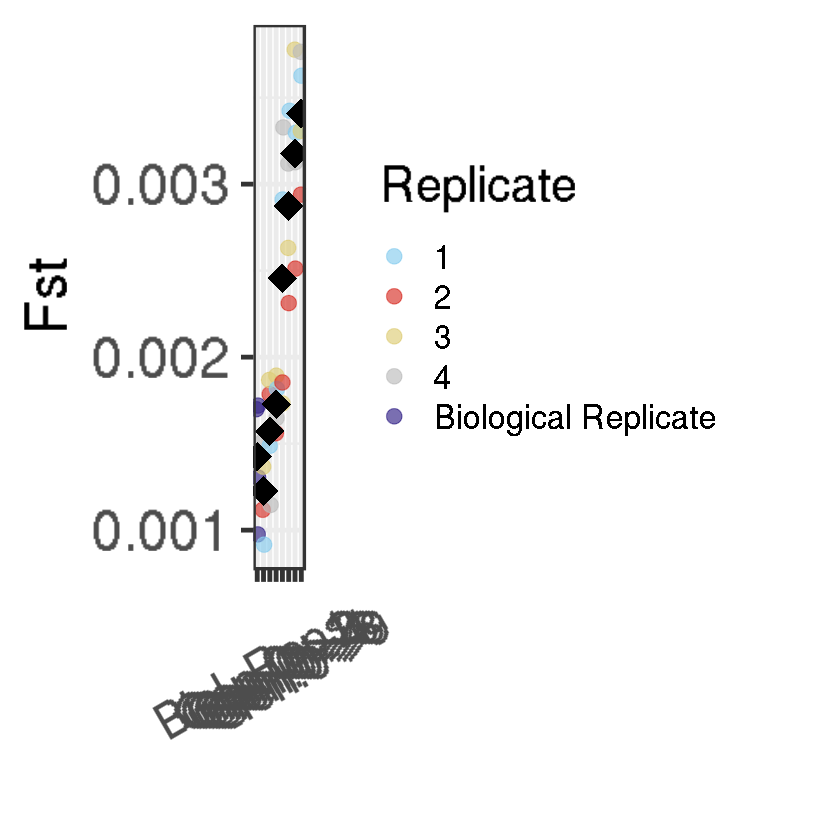

In [17]:
####Figure 2A - Plotting Fst among biological replicates and through time:

##Plotting genome-wide fst through expansion, including biological reps - 
#1) bind biol rep fst to evolved sample fst:
biol.rep = read.csv('./Biol.Reps.Fst.csv')
biol.rep$type = 'biol.rep'
biol.rep = biol.rep %>% dplyr::select(type, fst)
biol.rep$comparison = 'Biol. Reps.'

evol.fst = read.csv('./indoor.Fst.BaseToEvolved.Meta.csv')
evol.fst$type = 'base.evolv'

#isolate instances in which we only compare the same cage
evol.fst = evol.fst %>% filter(comp.cage == ref.cage)

evol.fst = evol.fst %>% filter(ref.tpt == '0' & comp.tpt != '0')
evol.fst =evol.fst %>% rowwise() %>% mutate(comparison = paste0('Gen.',ref.tpt, '->',  comp.tpt))
biol.rep$ref.cage = 'Biological Replicate'
evol.fst = evol.fst %>% dplyr::select(type, fst, ref.cage, comparison)




fst.df = rbind(evol.fst, biol.rep)
fst.df = as.data.frame(fst.df)
summary_stats = aggregate(fst ~ comparison, data = fst.df, FUN = function(x) c(mean = mean(x), sd = sd(x)))
summary_stats = summary_stats %>% rowwise() %>% mutate(mean = (strsplit(as.character(fst), ', '))[[1]][1])  
summary_stats = summary_stats %>% dplyr::select(-fst)

fst.df = merge(fst.df, summary_stats, by = 'comparison')                          
fst.df$mean = as.numeric(fst.df$mean)  

fst.df = fst.df %>% rename(Replicate = ref.cage)
                          

p = ggplot(fst.df, aes(x = comparison, y = mean)) +
  geom_jitter(data = fst.df, aes(y = fst, colour = Replicate), width = 0.15, size = 4, alpha = 0.65) + # Individual points
  scale_colour_manual(values = c('#88CCEE','#D73027', '#DDCC77','#BBBBBB', '#332288')) +
  geom_point(color = "black", size = 8, shape = 'diamond') + # Mean point
  labs(x = "", y = "Fst") +
  theme_bw(base_size = 30) +
  theme(axis.text.x = element_text(size = 30, angle = 30, hjust = 0.5, vjust = 0.5),
       axis.text.y = element_text(size = 35),
        axis.title=element_text(size=35))
p
ggsave('./BaseToEvolFst.Meta.pdf', p, width = 15, height = 10)                          

In [18]:
#ANOVA looking at fst differentiation through time and relative to biological replicates
summary(aov(formula = fst ~ type, data = fst.df %>% filter(!comparison %in% c('t0->1'))))
summary(aov(formula = fst ~ type, data = fst.df %>% filter(comparison %in% c('Gen.0->1', 'Biol. Reps.'))))


            Df    Sum Sq   Mean Sq F value Pr(>F)  
type         1 2.996e-06 2.996e-06   4.056 0.0531 .
Residuals   30 2.216e-05 7.388e-07                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df    Sum Sq  Mean Sq F value Pr(>F)
type         1 7.710e-08 7.71e-08   0.782  0.411
Residuals    6 5.916e-07 9.86e-08               

In [ ]:
#Comparing Fst through time using a linear mixed effects model
##here is the code, but I ran this on my local computer due to challenges running lme4 on the cluster

fst.tpts = fst.df %>% filter(type != 'biol.rep')
fst.tpts = fst.tpts %>% rowwise() %>% mutate(tpt = strsplit(as.character(comparison), '->')[[1]][2]) %>%
    mutate(tpt = as.numeric(as.character(tpt)))
fst.tpts = as.data.frame(fst.tpts)

library(lmerTest)



m_full <- lmer(fst ~ tpt * ref.cage + (1 | ref.cage), data = fst.tpts)
anova(m_full, type = 3)

###RESULTS
#Sum Sq	Mean Sq	NumDF	DenDF	F value	Pr(>F)
#tpt	2.043410e-05	2.043410e-05	1	20	400.9657168	1.055410e-14
#ref.cage	1.080726e-07	3.602419e-08	3	20	0.7068804	5.591237e-01
#tpt:ref.cage	1.019008e-06	3.396693e-07	3	20	6.6651213	2.669812e-03

# Fst-MDS analyses  - Fig's 2B, 2C, 2D, 3A, 3B


In [ ]:
##First, conduct MDS on pairwise Fst matrix of expansion samples:
#load in RData and isolate expansion and truncation samples
load('./Experiment1_PopulationExpansionTruncation.RData', verbose = TRUE)
df = cbind(samps, t(afmat))
df = df %>% filter(phase %in% c('exp1', 'exp2', 'trunc1')) %>% 
    mutate(phase = case_when(phase == 'exp1' ~ 'expansion', 
                                          phase == 'exp2' ~ 'expansion',
                                          phase == 'trunc1' ~'truncation'))

df = df %>% filter(phase %in% c('expansion', 'truncation')) %>% filter(tpt != '23')

#but now just isolate expansion samples:
df = df %>% filter(phase == 'expansion')
samps = df[,c(1:5)]
df = df[,-c(1:5)]
df = as.data.frame(t(df))
fst.mat = Fst.mat(df)
write.csv(fst.mat, './FstMat.ExpansionSamps.csv')

#get mds
mds_result <- cmdscale(fst.mat)
mds_results = as.data.frame(mds_result)
mds_results = cbind(samps, mds_results)


write.csv(mds_results, './Fst.MDS.ExpansionSamps.csv', row.names = FALSE)

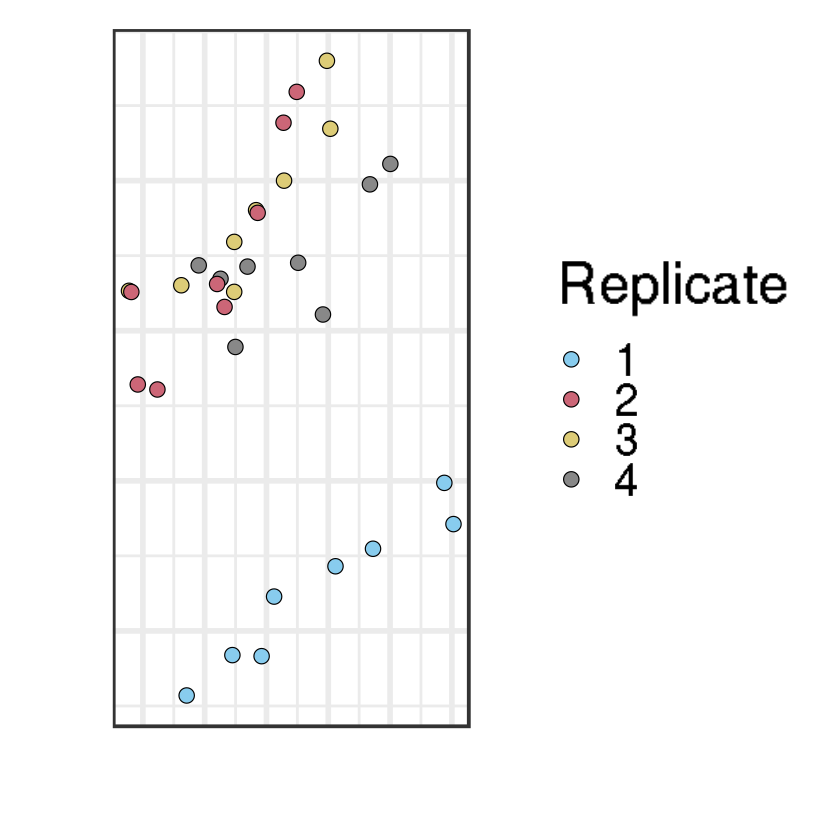

In [8]:
##Figure 2B: mds of parwise-Fst between expansion samples, colored by replicate cage
mds_results = read.csv('./Fst.MDS.ExpansionSamps.csv')
expansionPal <- colorRampPalette(brewer.pal(8, "Purples")) 
truncationPal <- colorRampPalette(brewer.pal(7, "YlOrBr"))
p.cage = ggplot(mds_results, aes(x = V1, y = V2, fill = as.factor(cage))) +
    scale_fill_carto_d(palette = "Safe") + 
      geom_point(size = 4, shape = 21) +
      theme_bw(base_size = 35) +
        theme(axis.text.x=element_blank(), 
          axis.ticks.x=element_blank(), 
          axis.text.y=element_blank(), 
          axis.ticks.y=element_blank()) +
        labs(fill = "Replicate") +
        xlab('') +
        ylab('')
p.cage

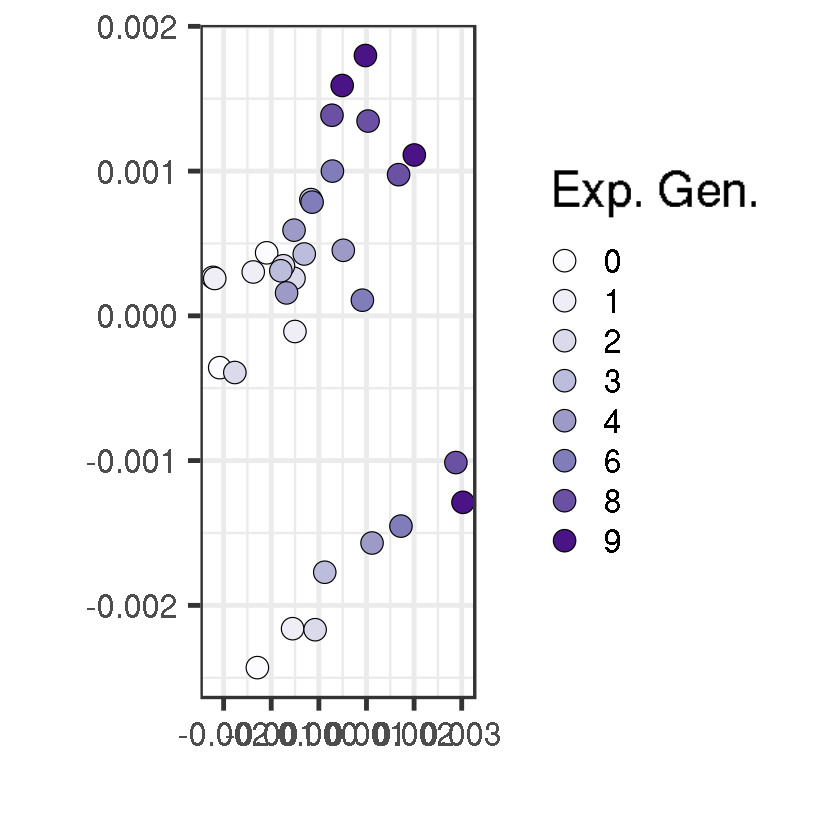

In [10]:
#Fig 3C: expansion sample mds on fst matrix, colred by time point 
p.tpt = ggplot(mds_results, aes(x = V1, y = V2, fill = as.factor(tpt))) +
      geom_point(size = 6, shape = 21) +
     scale_fill_manual(values = c(expansionPal(8))) +
      theme_bw(base_size = 30) +
        #theme(axis.text.x=element_blank(), 
         # axis.ticks.x=element_blank(), 
          #axis.text.y=element_blank(), 
          #axis.ticks.y=element_blank()) +
        labs(fill = "Exp. Gen.") +
        xlab('') +
        ylab('')
p.tpt
ggsave('./Fst.MDS.Expansion.pdf', p.tpt, width = 12, height = 10)

In [2]:
##Now, get pairwise Fst across all expansion and truncation samples:
##note: excluding truncation hour 23 sample b/c of the low number of flies and noisy allele frequency estimates

#load in RData and isolate expansion and truncation samples
load('./Experiment1_PopulationExpansionTruncation.RData', verbose = TRUE)
df = cbind(samps, t(afmat))
df = df %>% filter(phase %in% c('exp1', 'exp2', 'trunc1')) %>% 
    mutate(phase = case_when(phase == 'exp1' ~ 'expansion', 
                                          phase == 'exp2' ~ 'expansion',
                                          phase == 'trunc1' ~'truncation'))

df = df %>% filter(phase %in% c('expansion', 'truncation')) %>% filter(tpt != '23')


df = df[,-c(1:5)]
df = as.data.frame(t(df))

samps = samps %>% filter(phase %in% c('exp1', 'exp2', 'trunc1')) %>% 
    mutate(phase = case_when(phase == 'exp1' ~ 'expansion', 
                                          phase == 'exp2' ~ 'expansion',
                                          phase == 'trunc1' ~'truncation')) %>% filter(phase %in% c('expansion', 'truncation')) %>% 
    filter(tpt != '23')

#generate pairwise Fst matrix
fst.mat = Fst.mat(df)
write.csv(fst.mat, './FstMat.AllSamps.csv', row.names = FALSE)
#generate MDS of pairwise Fst across all samples:
fst.mat = read.csv('./FstMat.AllSamps.csv')
mds_result <- cmdscale(as.matrix(fst.mat), eig = TRUE)
mds_result <- as.data.frame(mds_result$points)
colnames(mds_result) <- c("V1", "V2")
mds_result = cbind(samps, mds_result)
write.csv(mds_result, './Fst.MDS.AllSamps.csv', row.names = FALSE)

Loading objects:
  sites
  samps
  afmat
  eec


In [37]:
mds_results = read.csv('./Fst.MDS.AllSamps.csv')



mds_results = mds_results %>% mutate(scale = if_else(phase == 'expansion', 'Gen.', 'Hr.')) %>%
    mutate(t = tpt) %>% mutate(tpt = paste0(scale, t))
expansionPal <- colorRampPalette(brewer.pal(8, "Purples")) 
truncationPal <- colorRampPalette(brewer.pal(7, "YlOrBr"))
mds_results = mds_results %>% rowwise() %>% 
            mutate(phase = if_else(phase == 'expansion', 'Expansion', 'Truncation') )
mds_results$tpt <- factor(mds_results$tpt, levels = c('Gen.0', 'Gen.1', 'Gen.2', 'Gen.3', 'Gen.4','Gen.6', 'Gen.8',
                                                     'Gen.9', 'Hr.0', 'Hr.6',  'Hr.9', 
                                                      'Hr.12', 'Hr.15', 'Hr.19', 'Hr.21' ))


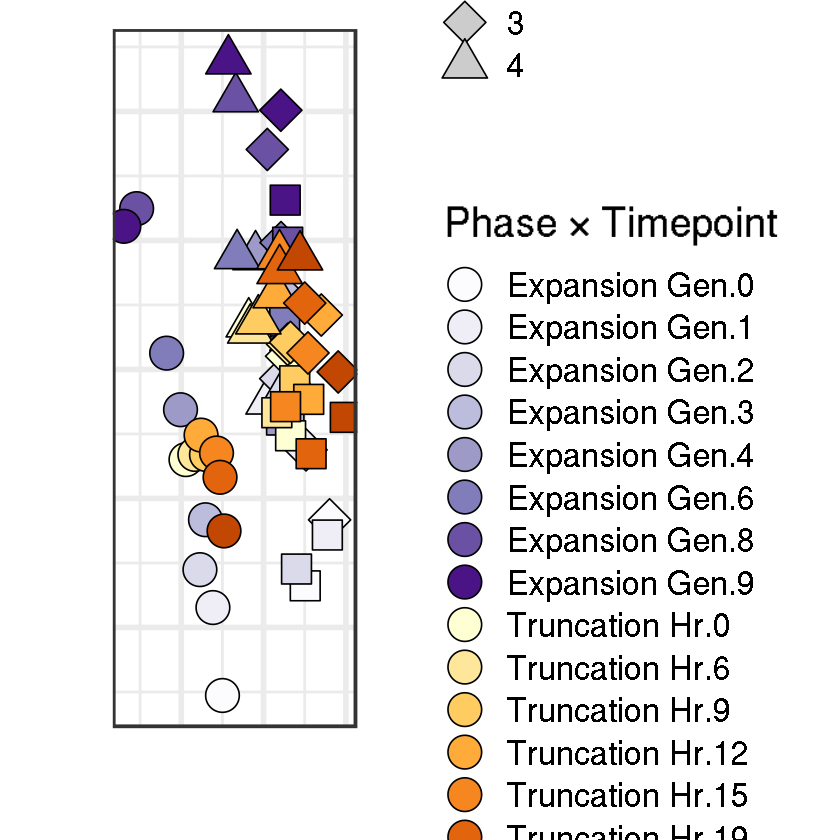

In [39]:
##Figure 3A:
p = ggplot(mds_results, aes(
  x = V1,
  y = V2,
  fill = interaction(phase, as.factor(tpt), sep = " "),
  shape = as.factor(cage)
)) +
  # note: do NOT re-map fill inside geom_point()
  geom_point(size = 9, color = "black", stroke = 0.7) +
  scale_fill_manual(
    values = c(expansionPal(8), truncationPal(8)),
    name = "Phase × Timepoint"
  ) +
  scale_shape_manual(
    values = c(21, 22, 23, 24, 25),
    name = "Cage"
  ) +
  guides(
    fill = guide_legend(override.aes = list(shape = 21, size = 9)),
    shape = guide_legend(override.aes = list(fill = "grey80", color = "black", size = 9))
  ) +
  theme_bw(base_size = 35) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title = element_text(size = 25),
    legend.text = element_text(size = 22),
    legend.box = "vertical",
    legend.position = "right"
  ) +
  xlab('') +
  ylab('')
p
ggsave('./MDS.Meta.pdf', p, height = 12, width = 15)

# MDS regressions

Now, we want to quantify whether or not there is truly a reversal of truncation samples back in towards early expansion samples.
Our method is to construct a simple linear regression using early expansion samples (expansion generation 0->4), then project the late expansion and truncation samples onto that 1-D axis to ask whether the expansion generation samples continue on in the same direction, while the truncation sampels revert backwards

In [13]:
#1) get mds data for expansion samps and truncation samps separately, from above

load('./Experiment1_PopulationExpansionTruncation.RData')
samps = samps %>% filter(phase %in% c('exp1', 'exp2', 'trunc1') & tpt != '23') %>% 
    mutate(phase = case_when(phase == 'exp1' ~ 'expansion', 
                                          phase == 'exp2' ~ 'expansion',
                                          phase == 'trunc1' ~'truncation'))


mds = read.csv('./Fst.MDS.AllSamps.csv')

mds = mds %>% rowwise() %>% 
   mutate(phase = case_when(phase == 'expansion' & tpt %in% c('0','1','2','3','4') ~ 'exp1',
                            phase == 'expansion' & tpt %in% c('6','7','8','9') ~ 'exp2',
                            phase == 'truncation' ~ 'trunc'))

In [16]:
#2) generate transformed data with exp 0 and trunc 0 as centroid of each cage/phase
phases = c('exp1', 'exp2')
cages = c('1','2','3','4')


#expansion transformation:
df.transformed.exp = data.frame()
for (p in phases){
    mds.p = mds %>% filter(phase == p)
    for (c in cages){ 
        df = mds.p %>% filter(cage == c)
        t0.x = as.numeric(mds %>% filter(cage == c) %>%
            filter(phase %in% c('exp1', 'exp2') & tpt == '0') %>% pull(V1)) #x coordinate of t0
        t0.y = as.numeric(mds %>% filter(cage == c) %>%
            filter(phase %in% c('exp1', 'exp2') & tpt == '0') %>% pull(V2))#y coordinate of t0
        df$translate.x=0
        df$translate.y=0
        df$project.x=0
        df$project.y=0
        df$dist=0
        df = df %>% rename(x = V1, y = V2)
        #translate each point around x/y
        df = df %>% rowwise() %>% mutate(translate.x = x - t0.x) 
        df = df %>% rowwise() %>% mutate(translate.y = y - t0.y)
        df.transformed.exp = rbind(df.transformed.exp, df)
        }
}
df.transformed.exp = as.data.frame(df.transformed.exp)
write.csv(df.transformed.exp, './Exp1BF.ExpansionTranslations.Empirical.csv', row.names = FALSE)

##truncation transformation:
phases = c('trunc')
cages = c('1','2','3','4')

df.transformed.trunc = data.frame()
for (p in phases){
    mds.p = mds %>% filter(phase == p)
    for (c in cages){ 
        df = mds.p %>% filter(cage == c)
        t0.x = as.numeric(mds %>% filter(cage == c) %>%
            filter(phase %in% c('trunc') & tpt == '0') %>% pull(V1)) #x coordinate of t0
        t0.y = as.numeric(mds %>% filter(cage == c) %>%
            filter(phase %in% c('trunc') & tpt == '0') %>% pull(V2))#y coordinate of t0
        df$translate.x=0
        df$translate.y=0
        df$project.x=0
        df$project.y=0
        df$dist=0
        df = df %>% rename(x = V1, y = V2)
        df = df %>% rowwise() %>% mutate(translate.x = x - t0.x)
        df = df %>% rowwise() %>% mutate(translate.y = y - t0.y)
        df.transformed.trunc = rbind(df.transformed.trunc, df)
        }
}
df.transformed.trunc = as.data.frame(df.transformed.trunc)
write.csv(df.transformed.trunc, './Exp1BF.TruncationTranslations.Empirical.csv', row.names = FALSE)

df.transformed = rbind(df.transformed.exp, df.transformed.trunc)
df.transformed$cage = as.numeric(df.transformed$cage)

In [17]:
#3) for each cage,  construct linear model using expansion1 time point data, then project the cages points onto it

phases = c('exp1', 'exp2', 'trunc')
cages = c('1','2','3','4')

df.projections.meta = data.frame()
df.correlations.meta = data.frame()

for (c in cages){
    df.transformed.exp1 = df.transformed %>% filter(phase == 'exp1' & cage == c)
    bf = lm(translate.y ~ translate.x, data = df.transformed.exp1)
    b1=coef(bf)[1]
    m1=coef(bf)[2]
    df.correlations = data.frame()
    for (p in phases){
        df = df.transformed %>% filter(phase == p & cage == c)
        projections=project_points(m1,b1,df$translate.x,df$translate.y)
        df$project.x=projections[,1]
        df$project.y=projections[,2]
        df$dist=projections[,3]
        df.projections.meta = rbind(df.projections.meta, df)
        ptc=data.frame(phase = p,cage=c, b1=b1,m1=m1,Cor=cor(df$tpt,df$dist))
        ptc=ptc %>% mutate(Cor = Cor * -1) #phase the correlation in regard to the slope of the original line
        df.correlations = rbind(df.correlations, ptc)
        df.correlations.meta = rbind(df.correlations.meta, df.correlations)
        }
        
    }
df.projections.meta = unique(df.projections.meta)
df.correlations.meta = unique(df.correlations.meta)
write.csv(df.projections.meta,'./Exp1BF.Projections.Empirical.csv' , row.names = FALSE)    
write.csv(df.correlations.meta,'./Exp1BF.Correlations.Empirical.csv' , row.names = FALSE)

In [23]:
#4. Now re-do w/ shuffled time points of expansion1 to get permutation-based null
df.projections.shuffled = data.frame()
for (i in 1:100){
    df.projections.meta = data.frame()
    for (c in cages){
    df.transformed.exp1 = df.transformed %>% filter(phase == 'exp1' & cage == c)
    bf = lm(translate.y ~ translate.x, data = df.transformed.exp1)
    b1=coef(bf)[1]
    m1=coef(bf)[2]
    df.projections = data.frame()
    for (p in phases){
        df = df.transformed %>% filter(phase == p & cage == c)
        df$iteration = i
        projections=project_points(m1,b1,df$translate.x,df$translate.y)
        df$project.x=projections[,1]
        df$project.y=projections[,2]
        df$dist=projections[,3]
        df = df %>%
          arrange(translate.x) %>%  # Sort by tpt and x columns
          mutate(tpt = sample(tpt))
        ptc=data.frame(phase = p,cage=c,b1=b1,m1=m1,iteration =i, Cor=cor(df$tpt,df$dist))
        ptc=ptc %>% mutate(Cor = Cor * -1) #phase slope in accordance with original line
        df.projections = rbind(df.projections, ptc)
        df.projections.meta = rbind(df.projections.meta, df.projections)
            }
        df.projections.shuffled = rbind(df.projections.shuffled, df.projections.meta)
        }

}
df.projections.shuffled = unique(df.projections.shuffled)
write.csv(df.projections.shuffled, './Exp1BF.Correlations.Shuffled.csv',row.names = FALSE)

In [24]:
#5. get pvalues for observed correlations using permutation-derived correlations, above:
df.emp = read.csv('./Exp1BF.Correlations.Empirical.csv')
df.shuff = read.csv('./Exp1BF.Correlations.Shuffled.csv')

data = data.frame()
for (i in 1:nrow(df.emp)){
    d = df.emp[i,]
    p = d %>% pull(phase)
    c = d %>% pull(cage)
    obs.cor = d %>% pull(Cor)
    obs.cor = abs(obs.cor) #absolute value of correlation
    d.s = df.shuff %>% filter(phase == p, cage == c)
    shuff.dist = abs(d.s$Cor) #absolute value of shuffled distribution
    p.val <- 1 - ecdf(shuff.dist)(obs.cor) #is the absolute value of the observed correlation significantly greater than the expected
    df.new = cbind(d, p.val)
    data = rbind(data, df.new)
    
}
data = unique(data)
data = data %>% filter(phase != 'exp1')



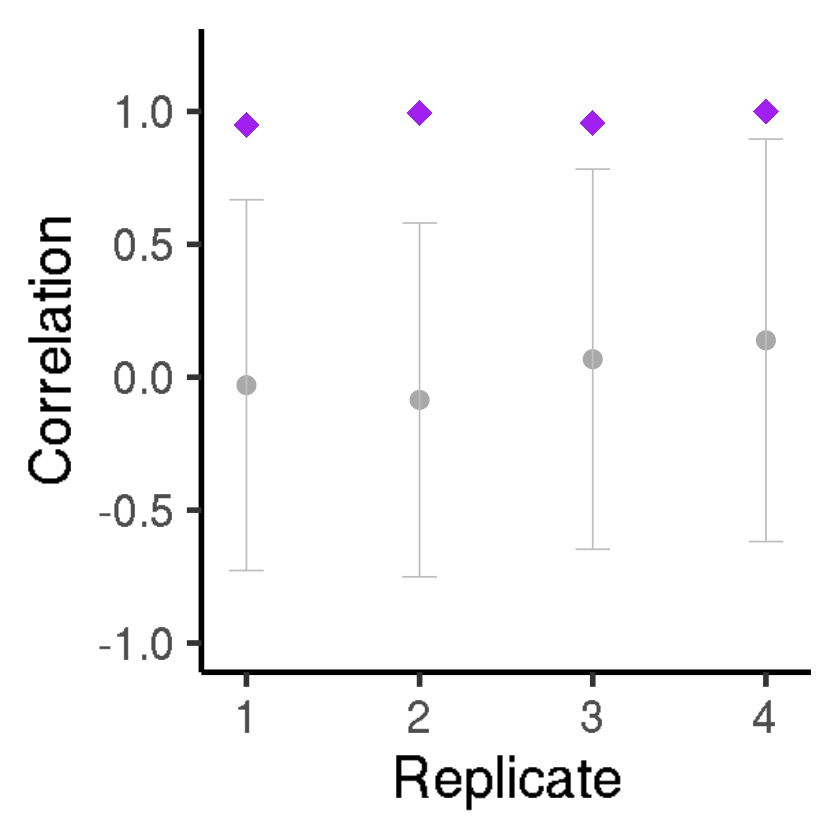

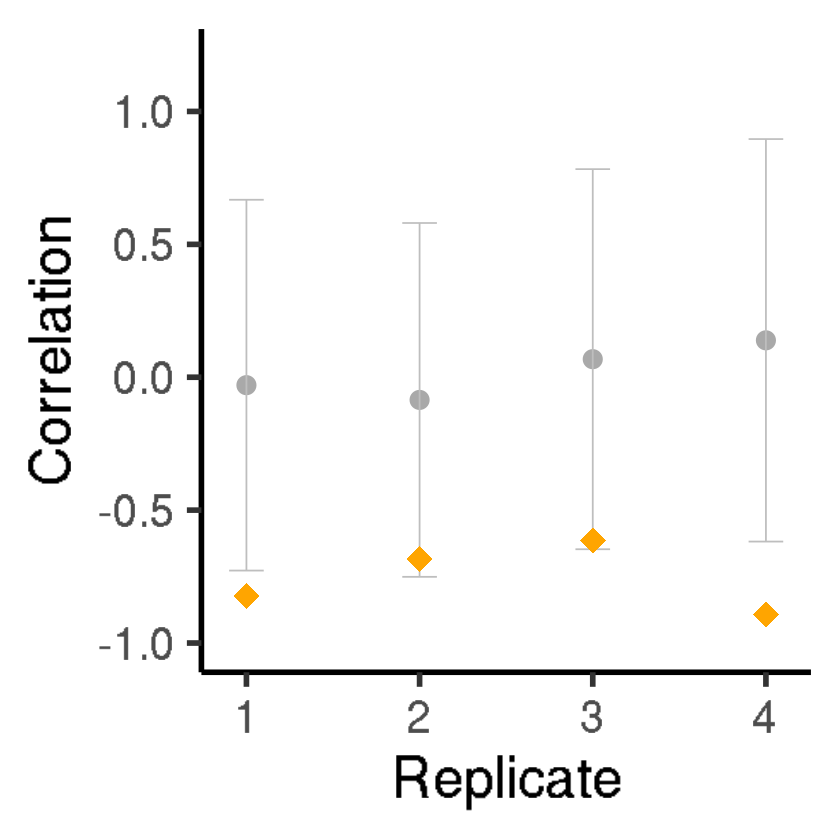

In [29]:
#Plotting observed vs. expected correlations by cage (Figures 2D and 3B):
df.emp = read.csv('./Exp1BF.Correlations.Empirical.csv')
df.shuff = read.csv('./Exp1BF.Correlations.Shuffled.csv')

df.emp = df.emp %>% dplyr::select(phase, cage, Cor)
df.emp$Type = 'Empirical'
df.shuff = df.shuff %>% dplyr::select(phase, cage, Cor)
df.shuff$Type = 'Shuffled'
df = rbind(df.emp, df.shuff)

df.exp = df %>% filter(phase == 'exp2')
df.trunc = df %>% filter(phase == 'trunc')

#get mean +/- sd shuffled values
shuffled_stats.exp <- df.exp %>%
  filter(Type == "Shuffled") %>%
  group_by(cage) %>%
  summarise(mean_Cor = mean(Cor), sd_Cor = sd(Cor))

shuffled_stats.trunc <- df.trunc %>%
  filter(Type == "Shuffled") %>%
  group_by(cage) %>%
  summarise(mean_Cor = mean(Cor), sd_Cor = sd(Cor))

# Get the empirical values
empirical_values.exp <- df.exp %>%
  filter(Type == "Empirical") %>%
  dplyr::select(cage, Cor) %>%
  rename(Cor_empirical = Cor)

empirical_values.trunc <- df.trunc %>%
  filter(Type == "Empirical") %>%
  dplyr::select(cage, Cor) %>%
  rename(Cor_empirical = Cor)

# Merge the statistics with the empirical values
plot_data.exp <- left_join(shuffled_stats.exp, empirical_values.exp, by = "cage")
plot_data.trunc <- left_join(shuffled_stats.exp, empirical_values.trunc, by = "cage")

# Plotting
p = ggplot() +
  # Add the mean +/- SD for shuffled values
  geom_point(data = plot_data.exp, aes(x = cage, y = mean_Cor), color = "dark grey", size = 5) +
  geom_errorbar(data = plot_data.exp, aes(x = cage, ymin = mean_Cor - sd_Cor, ymax = mean_Cor + sd_Cor), width = 0.2, color = "grey") +
  # Add the empirical points
  geom_point(data = plot_data.exp, aes(x = cage, y = Cor_empirical), color = "purple", size = 7, shape = 18) +
  # Customize the plot
  labs(x = "Replicate",
       y = "Correlation") +
    ylim(c(-1, 1.2)) +
  theme_classic(base_size = 35)
p
ggsave('./ProjectionCorrelations.Expansion.pdf', p, height = 10, width = 10 )

p = ggplot() +
  # Add the mean +/- SD for shuffled values
  geom_point(data = plot_data.trunc, aes(x = cage, y = mean_Cor), color = "dark grey", size = 5) +
  geom_errorbar(data = plot_data.trunc, aes(x = cage, ymin = mean_Cor - sd_Cor, ymax = mean_Cor + sd_Cor), width = 0.2, color = "grey") +
  # Add the empirical points
  geom_point(data = plot_data.trunc, aes(x = cage, y = Cor_empirical), color = "orange", size = 7, shape = 18) +
  # Customize the plot
  labs(x = "Replicate",
       y = "Correlation") +
    ylim(c(-1, 1.2)) +
  theme_classic(base_size = 35)

p
ggsave('./ProjectionCorrelations.Truncation.pdf', p, height = 10, width = 10 )